## Non-negative Matrix Factorization(NMF) aims to factorize a matrix into two lower-dimensional non-negative matrices.
### X(samples × genotypes)​≈W(samples × OTUs) ​× H(OTUs × genotypes)​
### W,H≥0 min‖X−WH‖_F^2
### Where ‖.‖_F denotes the Frobenius norm.
### In this notebook, we demonstrate the application of NMF on synthetic biological sequence data.

In [1]:
import numpy as np
import pandas as pd
import random
import string
from sklearn.decomposition import NMF
import seaborn as sns
import matplotlib.pyplot as plt

### Simulation data includes W(samples × OTUs), H(OTUs × genotypes) and X(samples × genotypes).

In [3]:
# =============================================================== #
# 1. generating simulation data about OTU genotypes and abundance #
# =============================================================== #
def generate_data_with_shared_mutations_encoded(
    n_groups=15, n_samples=300, seq_len=1000, seq_per_group=(10, 20),
    shared_mut_range=(10, 40), unique_mut_rate=0.02, seed=42
):
    random.seed(seed)
    np.random.seed(seed)
    
    base_dict = {'A':0, 'T':1, 'C':2, 'G':3}
    rev_dict = {v:k for k,v in base_dict.items()}

    all_seqs = []
    group_ids = []
    shared_mutations = {}

    for g in range(n_groups):
        n_seq = random.randint(*seq_per_group)
        base = np.array(['A'] * seq_len) ## basic sequence all 'A's

        # mutatings shared by all sequences in the OTUs, OTUs' genotypes or defining mutations
        n_shared = random.randint(*shared_mut_range)
        shared_pos = random.sample(range(seq_len), n_shared)
        shared_bases = {p: random.choice([b for b in "TCG"]) for p in shared_pos}
        shared_mutations[g] = shared_bases

        # generate the base sequence for the group (base2)
        base2 = base.copy()
        for p, b in shared_bases.items():
            base2[p] = b

        # add random mutations unique to each sequence in the OTU
        for _ in range(n_seq):
            seq = base2.copy()
            n_unique = int(seq_len * unique_mut_rate)
            if n_unique > 0:
                muts = random.sample(range(seq_len), n_unique)
                for p in muts:
                    seq[p] = random.choice([b for b in "ATCG" if b != seq[p]])
            all_seqs.append(''.join(seq))
            group_ids.append(g)

    n_total_seq = len(all_seqs)
    proportions = np.random.dirichlet(alpha=np.ones(n_groups), size=n_samples)

    # abundance matrix (samples x sequences)
    X_seq = np.zeros((n_samples, n_total_seq))
    for i in range(n_samples):
        for g in range(n_groups):
            idxs = [j for j, gid in enumerate(group_ids) if gid == g]
            if len(idxs) > 0:
                X_seq[i, idxs] = proportions[i, g] * np.random.rand(len(idxs))

    # transform bases of all_seqs to integers A=0/T=1/C=2/G=3
    seq_matrix = np.array([[base_dict[b] for b in s] for s in all_seqs])  # shape=(n_seq, seq_len)

    # construct one-hot encoding (seq_len * 4)
    one_hot = np.eye(4)[seq_matrix]  # (n_seq, seq_len, 4) ##A: [1,0,0,0], T: [0,1,0,0], C: [0,0,1,0], G: [0,0,0,1]
    one_hot = one_hot.reshape(n_total_seq, seq_len * 4)
    # if a sequences=ACGG, then one_hot encoding is:
    # one_hot row = [1,0,0,0, 0,0,1,0, 0,0,0,1, 0,0,0,1]
    # 计算样品×位点×碱基加权和
    X = X_seq @ one_hot  # shape=(n_samples, seq_len*4)
    # X_seq.shape = (n_samples, n_total_seq)    # samples × sequences abundance
    # one_hot.shape = (n_total_seq, seq_len*4)  # sequences × genotype*4
    # X.shape = (n_samples, seq_len*4)          # samples × genotype*4 (weighted by sequences abundance)
    return X, np.array(group_ids), proportions, shared_mutations, all_seqs, seq_matrix




### NMF and OTUs genotypes reconstruction

In [4]:
# ===================================== #
# 2. non-negative matrix factorization  #
# ===================================== #
def run_nmf(X, n_components=15, random_state=42, max_iter=100):
    model = NMF(n_components=n_components, init='nndsvda', max_iter=max_iter, random_state=random_state)
    W = model.fit_transform(X)
    H = model.components_
    return W, H


# ============================= #
# 3. computing Jaccard distance #
# ============================= #
def compute_jaccard_similarity(shared_mutations, H, seq_len):
    ## evaluate the reconstruction using Jaccard similarity
    base_dict = {'A':0, 'T':1, 'C':2, 'G':3}
    rev_dict = {v:k for k,v in base_dict.items()}

    n_components = H.shape[0]
    n_groups = len(shared_mutations)
    jaccard = np.zeros((n_components, n_groups))

    # reconstructed OTUs genotypes from H (NMF components)
    H_reshaped = H.reshape(n_components, seq_len, 4)
    comp_bases = np.argmax(H_reshaped, axis=-1)  # identifying the base with highest weight

    for k in range(n_components):
        comp_set = {i: rev_dict[b] for i, b in enumerate(comp_bases[k]) if b != 0}  # find mutations not 'A'
        for g, muts in shared_mutations.items():
            inter = len({p for p,b in comp_set.items() if p in muts and muts[p]==b})
            union = len(set(comp_set.keys()) | set(muts.keys()))
            jaccard[k,g] = inter / union if union > 0 else 0

    return jaccard



/home/houm/.conda/envs/dlearn/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(


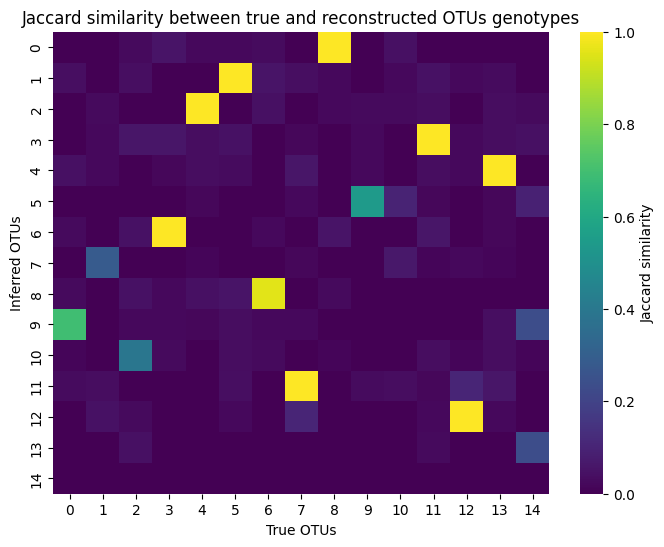

best-match Jaccard: 0     1.000000
1     1.000000
2     1.000000
3     1.000000
4     1.000000
6     1.000000
12    1.000000
11    1.000000
8     0.956522
9     0.692308
5     0.541667
10    0.390625
7     0.282051
13    0.230769
14    0.000000
dtype: float64
average best-match Jaccard: 0.7395961073950204


In [9]:
# ===================================== #
# 4. demonstration of the main function #
# ===================================== #
if __name__ == "__main__":
    ## generate simulation data
    seq_len = 200
    X, group_ids, proportions, shared_mutations, all_seqs, seq_matrix = generate_data_with_shared_mutations_encoded(
        n_groups=15, n_samples=400, seq_len=seq_len, seed=123)
    ## non-negative matrix factorization
    W, H = run_nmf(X, n_components=15)
    ## evaluate the reconstruction using Jaccard similarity
    jaccard = compute_jaccard_similarity(shared_mutations, H, seq_len)
    ##visualize the Jaccard similarity matrix
    plt.figure(figsize=(8,6))
    heatmap=sns.heatmap(jaccard, cmap="viridis", vmin=0, vmax=1,cbar_kws={'label': 'Jaccard similarity'})
    plt.xlabel("True OTUs")
    plt.ylabel("Inferred OTUs")
    plt.title("Jaccard similarity between true and reconstructed OTUs genotypes")
    plt.show()

    print("best-match Jaccard:", pd.Series(jaccard.max(axis=1)).sort_values(ascending=False))
    print("average best-match Jaccard:", jaccard.max(axis=1).mean())